In [1]:
import matplotlib
import numpy as np
import random
import pandas as pd
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [19]:
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

In [20]:
M = 1
N = 10**4
b = 1
m = M/N
G = 1

In [21]:
r_cdf = np.random.uniform(0,1,N)
R = b * np.sqrt(r_cdf**(2/3)/(1- r_cdf**(2/3)))
theta_cdf = np.random.uniform(0,1,N)
theta = np.arccos(1 - 2 * theta_cdf)
phi = np.random.uniform(0, 2 * np.pi, size=N) 

In [22]:
x = R * np.cos(phi) * np.sin(theta)
y = R * np.sin(phi) * np.sin(theta)
z = R * np.cos(theta)

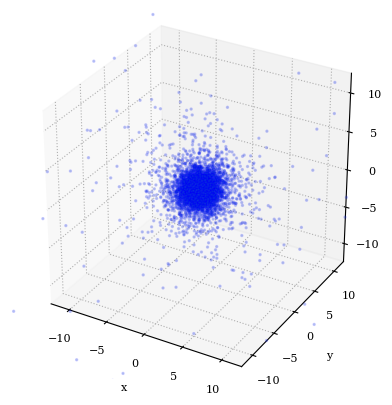

In [33]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

l = 12
ax.set_xlim(-l, l)
ax.set_ylim(-l, l)
ax.set_zlim(-l, l)
ax.scatter(x, y, z,alpha = .2, s=2)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show();

In [35]:
Psi = G * M /(R**2 + b**2)**(1/2)

In [36]:
pdf_test = lambda x: (x**2*(1-x**2)**(3.5))
A = integrate.quad(pdf_test,0,1)
q = np.linspace(0,1,100000)
pdf = 1/A[0]*(q**2*(1-q**2)**(3.5))
pdf_func = lambda x: 1/A[0]*(x**2*(1-x**2)**(3.5))
g = np.ones(100000)*np.max(pdf)

In [37]:
q_sample = []

for i in range(N):
    y_rand = np.max(g) + 1
    rand = np.random.uniform(0,1)
    while y_rand > pdf_func(rand):
        rand = np.random.uniform(0,1)
        y_rand = np.random.uniform(0,np.max(g))

    q_sample.append(rand)

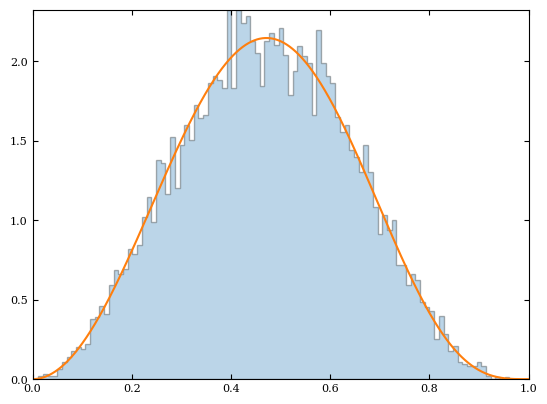

In [40]:
q_sample = np.array(q_sample)
plt.hist(q_sample,100, density=True, histtype='stepfilled', alpha = .3)
plt.plot(q,pdf);

In [41]:
v = q_sample * np.sqrt(2 * Psi)
v_theta_cdf = np.random.uniform(0,1,N)
v_theta = np.arccos(1 - 2 * v_theta_cdf)
v_phi = np.random.uniform(0, 2 * np.pi, size=N) 


In [42]:
v_x = v * np.cos(v_phi) * np.sin(v_theta)
v_y = v * np.sin(v_phi) * np.sin(v_theta)
v_z = v * np.cos(v_theta)

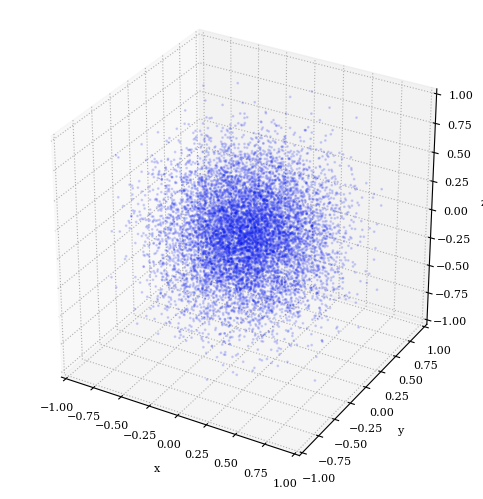

In [59]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.scatter(v_x, v_y, v_z, s=1, alpha = 0.15)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show();

In [61]:
# creating the input file
m_arr = m * np.ones(N)
dim = 3


with open ('in_data.txt', 'w+') as f:
    f.write(str(N) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in m_arr:
        f.write(f'{m_i}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')

In [62]:
mask = R<b
V = 4/3 * np.pi * b**3
rho = np.sum(m_arr[mask])/ V

In [77]:
epsilon = 1/10 * (V/N)**(1/3)
T = np.sqrt(3 * np.pi/ (16* G * rho) )
print(epsilon)

0.007482203853636491


In [82]:
T_sim = 20 * T
dt = 1/32
theta = 0.2
t_out = 2 * dt

52.48394462602876


In [84]:
import os
os.system('time ./tree/treecode in=in_data.txt out=out_data.txt dtime='+ str(dt) + 'eps='+str(epsilon)+' theta='+str(theta)+ 'tstop='+str(T_sim) +'dtout='+str(t_out)+' >log.txt')


real	0m26.124s
user	0m26.028s
sys	0m0.040s


0

In [80]:
import pandas as pd

### softening
lines = pd.read_csv('out_data.txt', names = list(range(3)), sep = '\s+')
N_particles = N
s = N*3+3

t_s = np.array([lines.iloc[2::s,0].copy().dropna()]).flatten()

m_s = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(3, N+3)])
x_s = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(N+3, 2*N+3)])
y_s = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(N+3, 2*N+3)])
z_s = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(N+3, 2*N+3)])
vx_s = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
vy_s = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
vz_s = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(2*N+3, 3*N+3)])

  0%|          | 0/27 [00:00<?, ?it/s]

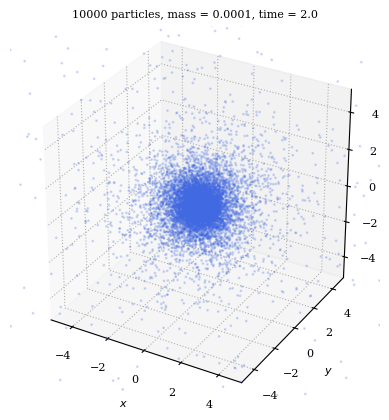

In [81]:
# simulation
from matplotlib import animation
from tqdm.notebook import tqdm

def update(num):
    global N    #N_particles
    l = 5
    ax.clear()
    
    ax.scatter(x_s[:,num-1], y_s[:,num-1], z_s[:,num-1], color = 'royalblue', s = 1 ,alpha = .2)        # Updating Point Location

    ax.set_title(f'{N} particles, mass = {round(m_s[0,0], 5)}, time = {round(t_s[num],1)}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    
    ax.set_xlim(-l, l)
    ax.set_ylim(-l, l)
    ax.set_zlim(-l, l)
    

## Plotting the Animation
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(aspect='equal')
line_ani = animation.FuncAnimation(fig, update, interval=1,   
                                   frames=tqdm(range(len(t_s))))

# Saving the Animation
f = r"plummer.gif"
writergif = animation.PillowWriter(fps=30)
line_ani.save(f, writer=writergif)

plt.show()